In [1]:
import numpy as np
import os
import tensorflow as tf
import boto3
import io
from PIL import Image
import matplotlib.pyplot as plt

2024-04-19 05:02:31.960151: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-19 05:02:32.277720: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-19 05:02:33.456587: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-19 05:02:35.218893: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


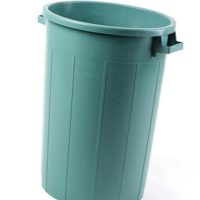

In [2]:
# Initialize S3 client
s3 = boto3.client('s3')

# Specify your bucket and prefix (directory)
bucket_name = 'bigdata-project-data'
prefix = 'uva-projects/nursing_home_data/basket_bin/'

# Use list_objects_v2 to list objects in the bucket with the specified prefix
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

# Iterate over the objects and open the first image
for obj in response.get('Contents', []):
    key = obj['Key']
    if key.lower().endswith('.jpg'):  # Assuming JPEG images
        # Download the image
        image_object = s3.get_object(Bucket=bucket_name, Key=key)
        # Open the image using PIL
        image = Image.open(io.BytesIO(image_object['Body'].read()))
        # Resize the image to a smaller size
        # Change (width, height) to your desired size
        smaller_image = image.resize((200, 200))
        # Display the resized image
        smaller_image.show()
        # Break out of the loop after opening the first image
        break

In [23]:
# Define your local data directory (where you want to download the data)
local_data_dir = '/home/sagemaker-user/bigdata-project/data'

# Use tf.keras.utils.image_dataset_from_directory with the local directory
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
    local_data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 37500 files belonging to 25 classes.
Using 30000 files for training.


In [24]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  local_data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 37500 files belonging to 25 classes.
Using 7500 files for validation.


In [26]:
len(train_ds.class_names)

25

2024-04-19 05:19:25.617517: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


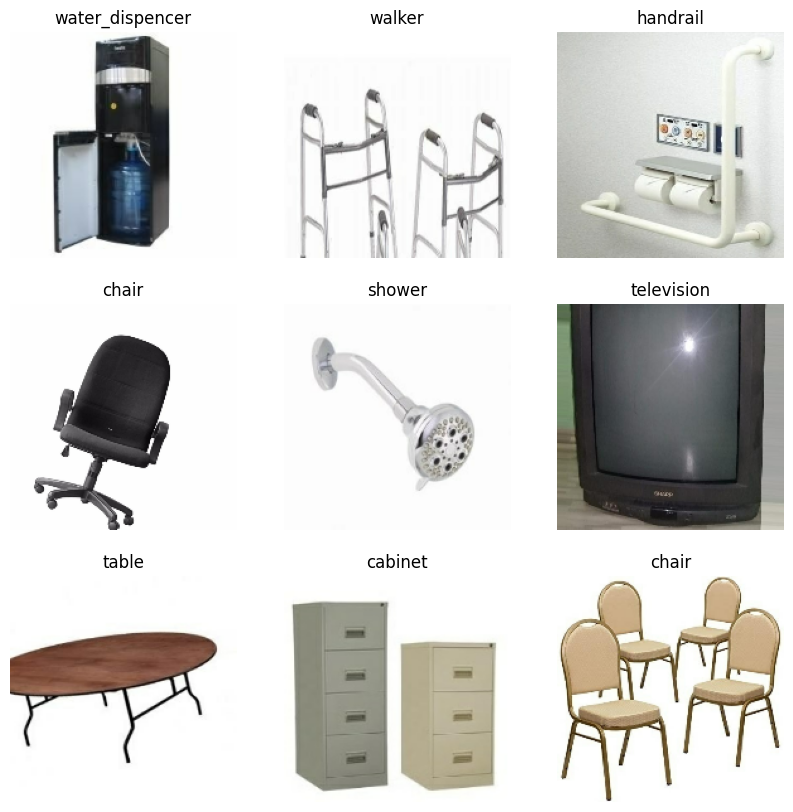

In [25]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [27]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

In [29]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 118
Number of test batches: 117


In [30]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [31]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

2024-04-19 04:32:07.368485: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


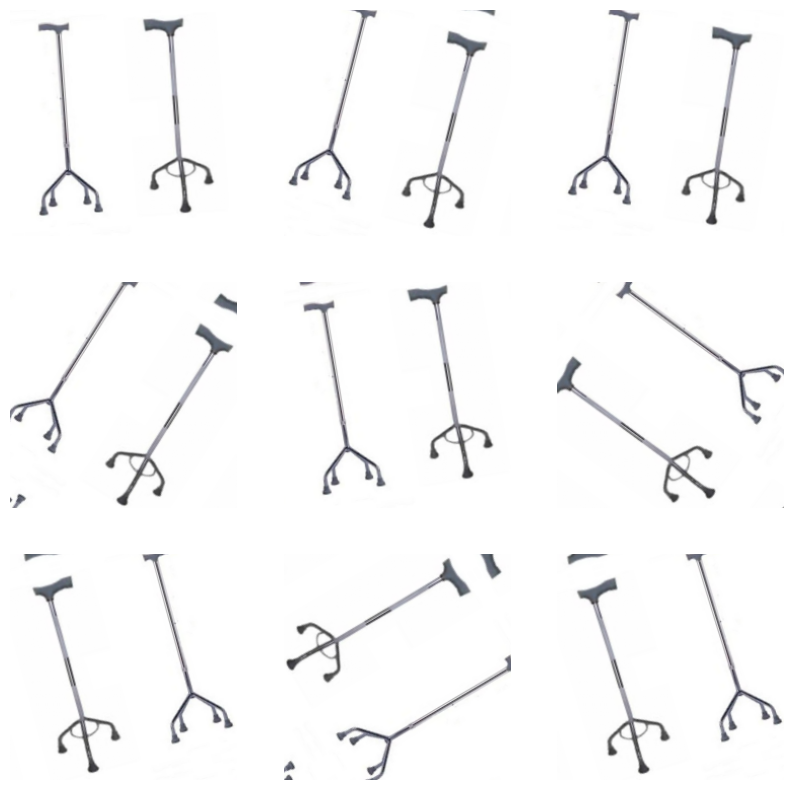

In [10]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [32]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

In [33]:
# Define the input shape and image size
IMG_SIZE = (180, 180)  # Assuming you want to use ResNet50's default input size
IMG_SHAPE = IMG_SIZE + (3,)

# Create the base model from the pre-trained ResNet50 model
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                            include_top=False,
                                            weights='imagenet')

In [34]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 2048)


In [35]:
base_model.trainable = False

In [36]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [37]:
prediction_layer = tf.keras.layers.Dense(25)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 25)


In [38]:
inputs = tf.keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [39]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 180, 180,  │          0 │ input_layer_5[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 180, 180)  │          0 │ sequential_1[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 180, 180)  │          0 │ sequential_1[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 180, 180)  │          0 │ sequential_1[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 180, 180,  │          0 │ get_item_3[0][0], │
│                     │ 3)                │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 180, 180,  │          0 │ stack_1[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 6, 6,      │ 23,587,712 │ add_1[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 25)        │     51,225 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,638,937 (90.18 MB)

 Trainable params: 51,225 (200.10 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [41]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [42]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

118/118 ━━━━━━━━━━━━━━━━━━━━ 75s 586ms/step - accuracy: 0.0408 - loss: 4.0453


In [43]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 4.05
initial accuracy: 0.04


In [47]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 641s 677ms/step - accuracy: 0.7510 - loss: 0.8562 - val_accuracy: 0.9329 - val_loss: 0.2156
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 640s 682ms/step - accuracy: 0.9143 - loss: 0.2708 - val_accuracy: 0.9380 - val_loss: 0.2043
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 639s 681ms/step - accuracy: 0.9303 - loss: 0.2231 - val_accuracy: 0.9486 - val_loss: 0.1893
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 637s 679ms/step - accuracy: 0.9359 - loss: 0.2029 - val_accuracy: 0.9481 - val_loss: 0.1882
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 640s 682ms/step - accuracy: 0.9422 - loss: 0.1840 - val_accuracy: 0.9563 - val_loss: 0.1675


In [ ]:
#model.save('my_model.keras')

In [ ]:
#model.save('/home/sagemaker-user/bigdata-project/resnet50-ep5-model.h5')

In [ ]:
#loaded_model = tf.keras.models.load_model('/home/sagemaker-user/bigdata-project/resnet50-ep5-model.h5')

Text(0.5, 1.0, 'Training and Validation Loss')

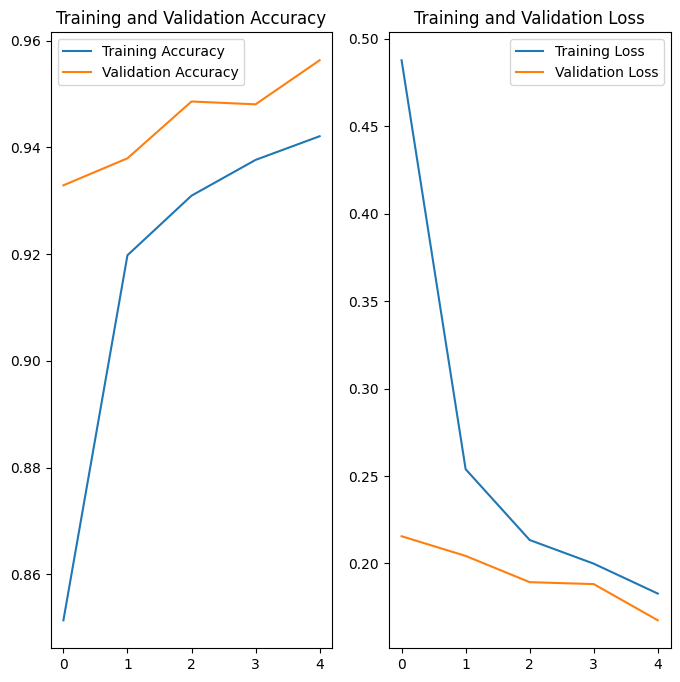

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [55]:
loss, accuracy = model.evaluate(test_ds)
print('Test Accuracy:', accuracy)
print('Test Loss:', loss)

117/117 ━━━━━━━━━━━━━━━━━━━━ 68s 583ms/step - accuracy: 0.9571 - loss: 0.1639
Test Accuracy: 0.9575320482254028
Test Loss: 0.1513185352087021


Predictions:
 [18 23 20  2 16  6  0 21 12  4 12  7  0 20 14  5  7  6 15 17 19 12  0 22
 23  4 20 14  5 10  2  1]
Labels:
 [18 23 20  2 16  6  0 21 12  4 12  7  0 20 14  5  7  6 15 17 19 12  0 22
 23  4 20 14 21 10 18  1]


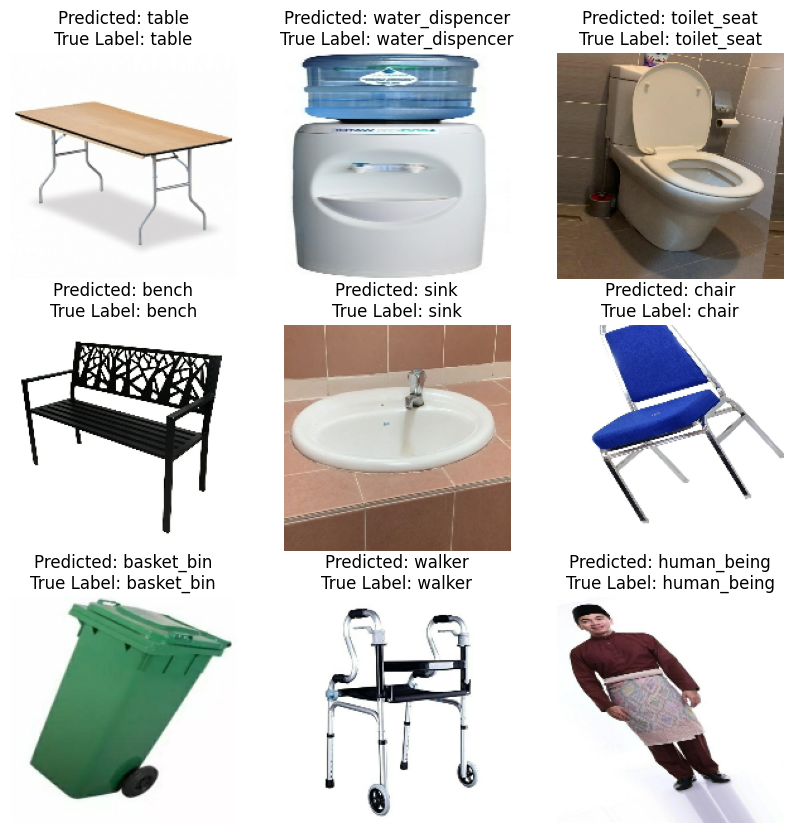

In [60]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()

predictions = model.predict_on_batch(image_batch)

# Apply softmax to convert logits to probabilities
predictions = tf.nn.softmax(predictions, axis=-1)

# Get the predicted class indices
predicted_class_indices = tf.argmax(predictions, axis=-1)

print('Predictions:\n', predicted_class_indices.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    predicted_class_index = predicted_class_indices[i].numpy()
    true_label = label_batch[i]
    plt.title(f"Predicted: {class_names[predicted_class_index]}\nTrue Label: {class_names[true_label]}")
    plt.axis("off")